# Understanding the local electricity market

## 📖 Background
You work for an energy company in Australia. Your company builds solar panel arrays and then sells the energy they produce to industrial customers. The company wants to expand to the city of Melbourne in the state of Victoria. 

Prices and demand for electricity change every day. Customers pay for the energy received using a formula based on the local energy market's daily price.



## 💾 The data
You have access to over five years of energy price and demand data:

- "date" - from January 1, 2015, to October 6, 2020.
- "demand" - daily electricity demand in MWh.
- "price" - recommended retail price in AUD/MWh.
- "demand_pos_price" - total daily demand at a positive price in MWh.
- "price_positive" - average positive price, weighted by the corresponding intraday demand in AUD/MWh.
- "demand_neg_price" - total daily demand at a negative price in MWh.
- "price_negative" - average negative price, weighted by the corresponding intraday demand in AUD/MWh.
- "frac_neg_price" - the fraction of the day when the demand traded at a negative price.
- "min_temperature" - minimum temperature during the day in Celsius.
- "max_temperature" - maximum temperature during the day in Celsius.
- "solar_exposure" - total daily sunlight energy in MJ/m^2.
- "rainfall" - daily rainfall in mm.
- "school_day" - "Y" if that day was a school day, "N" otherwise.
- "holiday" - "Y" if the day was a state or national holiday, "N" otherwise.

Note: The price was negative during some intraday intervals, so energy producers were paying buyers rather than vice-versa.

In [1]:
#Loading libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
#Loading file with data and display first 5 rows
df = pd.read_csv('./data/energy_demand.csv', parse_dates=['date'])
df.head(5)

,date,demand,price,demand_pos_price,price_positive,demand_neg_price,price_negative,frac_neg_price,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday
0,2015-01-01,99635.030,25.633696,97319.240,26.415953,2315.790,-7.240000,0.020833,13.3,26.9,23.6,0.0,N,Y
1,2015-01-02,129606.010,33.138988,121082.015,38.837661,8523.995,-47.809777,0.062500,15.4,38.8,26.8,0.0,N,N
2,2015-01-03,142300.540,34.564855,142300.540,34.564855,0.000,0.000000,0.000000,20.0,38.2,26.5,0.0,N,N
3,2015-01-04,104330.715,25.005560,104330.715,25.005560,0.000,0.000000,0.000000,16.3,21.4,25.2,4.2,N,N
4,2015-01-05,118132.200,26.724176,118132.200,26.724176,0.000,0.000000,0.000000,15.0,22.0,30.7,0.0,N,N


In [3]:
#General information about data
df_info = df.info()
df.dropna(inplace=True)
display(df_info)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2106 entries, 0 to 2105
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              2106 non-null   datetime64[ns]
 1   demand            2106 non-null   float64       
 2   price             2106 non-null   float64       
 3   demand_pos_price  2106 non-null   float64       
 4   price_positive    2106 non-null   float64       
 5   demand_neg_price  2106 non-null   float64       
 6   price_negative    2106 non-null   float64       
 7   frac_neg_price    2106 non-null   float64       
 8   min_temperature   2106 non-null   float64       
 9   max_temperature   2106 non-null   float64       
 10  solar_exposure    2105 non-null   float64       
 11  rainfall          2103 non-null   float64       
 12  school_day        2106 non-null   object        
 13  holiday           2106 non-null   object        
dtypes: datetime64[ns](1), fl

None

In [4]:
#Statistical information 
df_with_float = df.drop(['date', 'school_day', 'holiday'], axis = 1)
df_with_float.describe()

,demand,price,demand_pos_price,price_positive,demand_neg_price,price_negative,frac_neg_price,min_temperature,max_temperature,solar_exposure,rainfall
count,2102.000000,2102.000000,2102.000000,2102.000000,2102.000000,2102.000000,2102.000000,2102.000000,2102.000000,2102.000000,2102.000000
mean,120036.408090,76.084873,119251.746306,76.560069,784.661784,-2.691163,0.008563,11.579924,20.415557,14.747526,1.505043
std,13747.235425,130.366950,14819.902317,130.234179,3582.162639,19.503619,0.039999,4.311288,6.289950,7.947423,4.308724
min,85094.375000,-6.076028,41988.240000,13.568986,0.000000,-342.220000,0.000000,0.600000,9.000000,0.700000,0.000000
25%,110011.593750,38.707040,109246.250000,39.117361,0.000000,0.000000,0.000000,8.500000,15.525000,8.200000,0.000000
50%,119605.242500,66.523630,119169.065000,66.853513,0.000000,0.000000,0.000000,11.300000,19.100000,12.750000,0.000000
75%,130436.006250,95.075012,130119.477500,95.130181,0.000000,0.000000,0.000000,14.600000,23.900000,20.775000,0.800000
max,170653.840000,4549.645105,170653.840000,4549.645105,57597.595000,0.000000,0.625000,28.000000,43.500000,33.300000,54.600000


<AxesSubplot:>

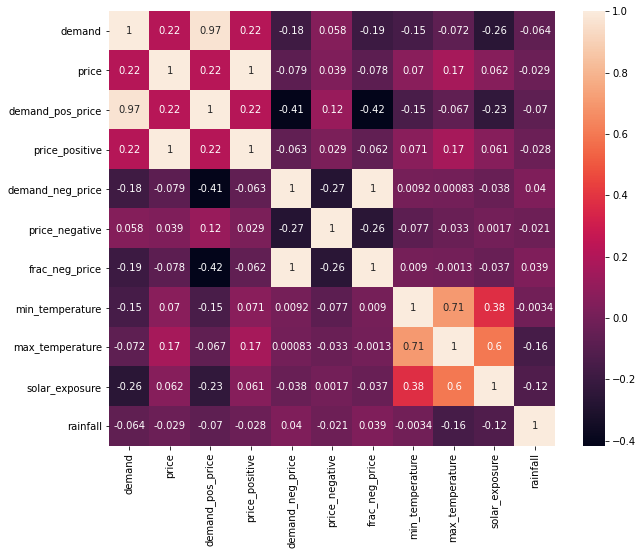

In [5]:
#Visualization of correlation between columns
df_corr = df_with_float.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(data = df_corr, annot = True)

<AxesSubplot:>

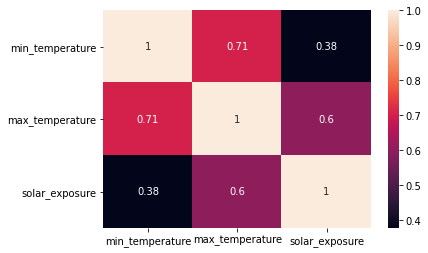

In [6]:
#Visualization between columns
df_corr_m = df[['min_temperature', 'max_temperature', 'solar_exposure']].corr()
sns.heatmap(data = df_corr_m, annot = True)

<AxesSubplot:>

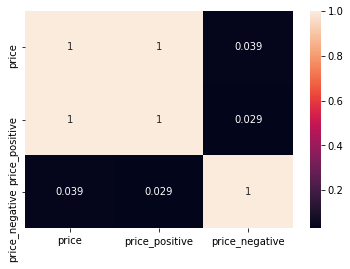

In [7]:
#Visualization between columns
df_corr_m = df[['price', 'price_positive', 'price_negative']].corr()
sns.heatmap(data = df_corr_m, annot = True)

<AxesSubplot:>

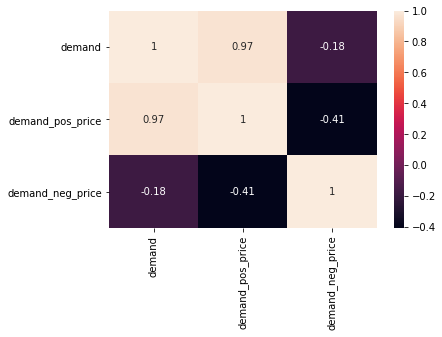

In [8]:
#Visualization between columns
df_corr_m = df[['demand', 'demand_pos_price', 'demand_neg_price']].corr()
sns.heatmap(data = df_corr_m, annot = True)

<Figure size 720x576 with 0 Axes>

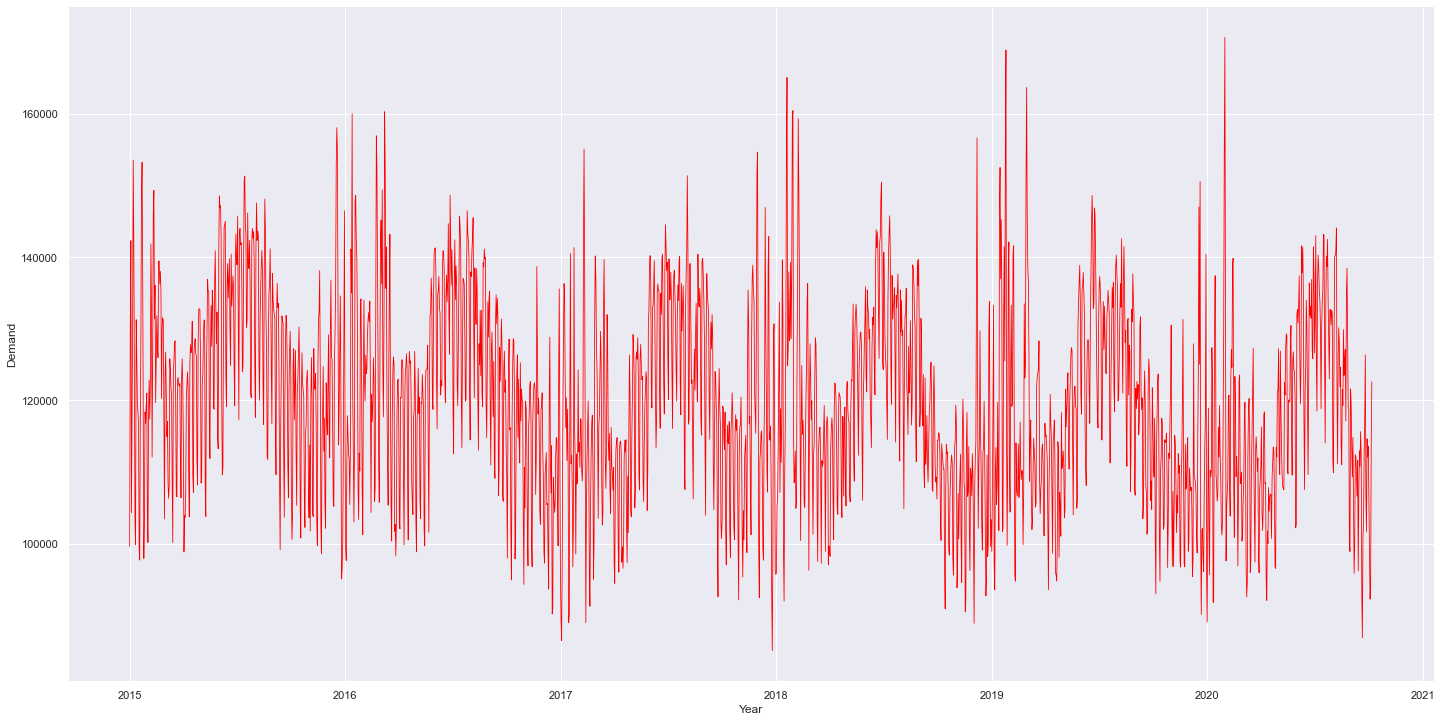

<Figure size 720x576 with 0 Axes>

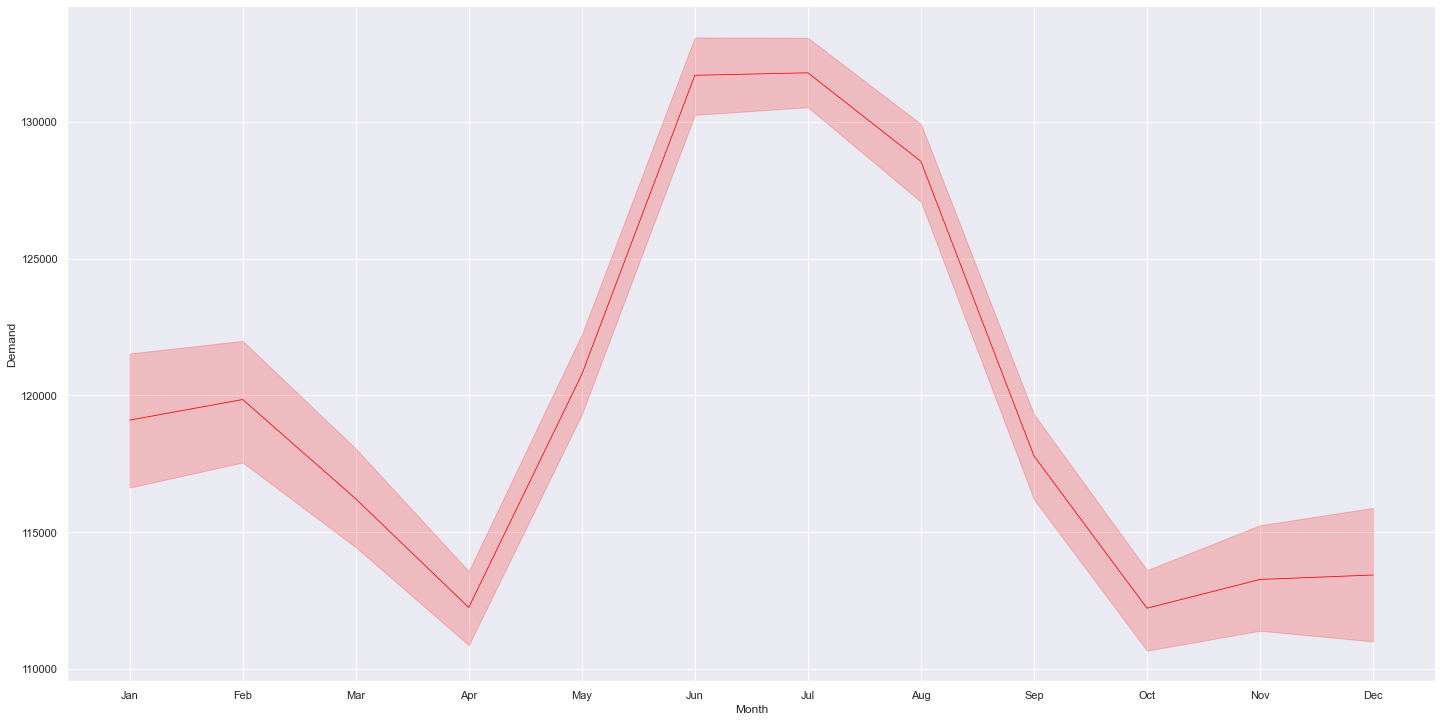

<Figure size 720x576 with 0 Axes>

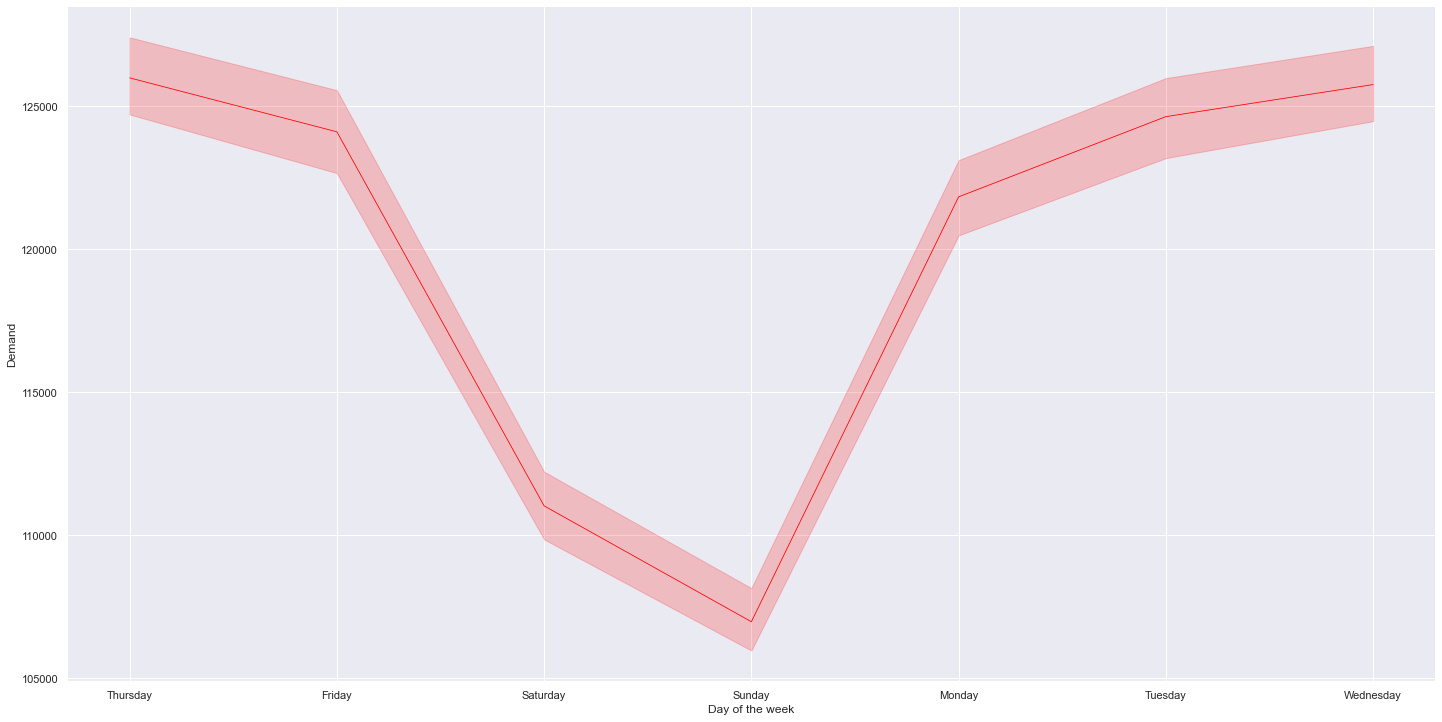

In [9]:
#Visualization of the relationship between date(year, month) and demand
plt.figure(figsize=(10, 8))
sns.set_theme(style = 'darkgrid')
fig = sns.relplot(
    x = 'date', y = 'demand', kind = 'line', 
    data = df, height = 10, aspect = 2, 
    linewidth = 0.8, color = 'red'
)
fig.set(xlabel = 'Year', ylabel = 'Demand')

df['date_month'] = df['date'].dt.strftime('%b')
df['date_year'] = df['date'].dt.year
df['date_day'] = df['date'].dt.strftime('%A')

plt.figure(figsize=(10, 8))
fig = sns.relplot(
    x = 'date_month', y = 'demand', 
    kind = 'line', data=df, height=10, aspect=2, 
    linewidth = 0.8, color = 'red'
)
fig.set(xlabel = 'Month', ylabel = 'Demand')

plt.figure(figsize=(10, 8))
fig = sns.relplot(
    x = 'date_day', y = 'demand', 
    kind = 'line', data=df, height=10, aspect=2, 
    linewidth = 0.8, color = 'red'
)
fig.set(xlabel = 'Day of the week', ylabel = 'Demand')

<Figure size 720x576 with 0 Axes>

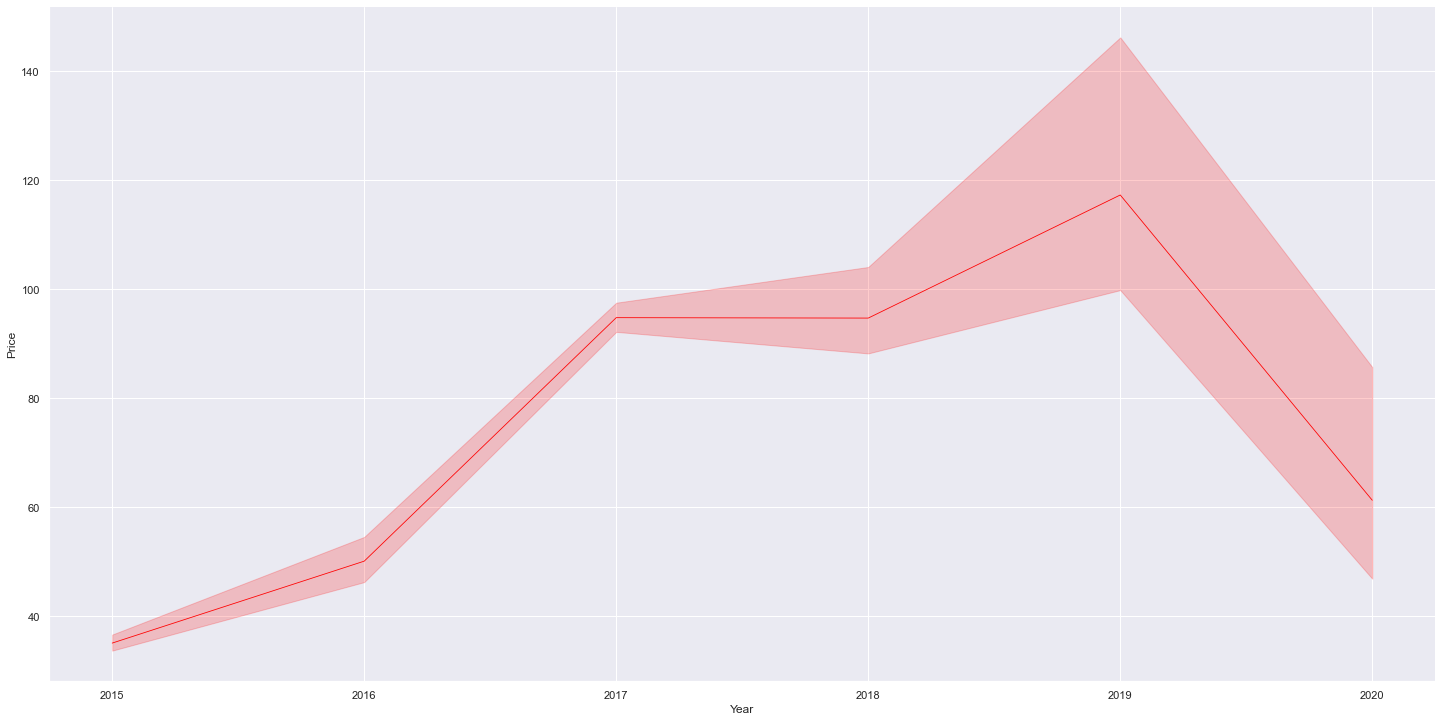

<Figure size 720x576 with 0 Axes>

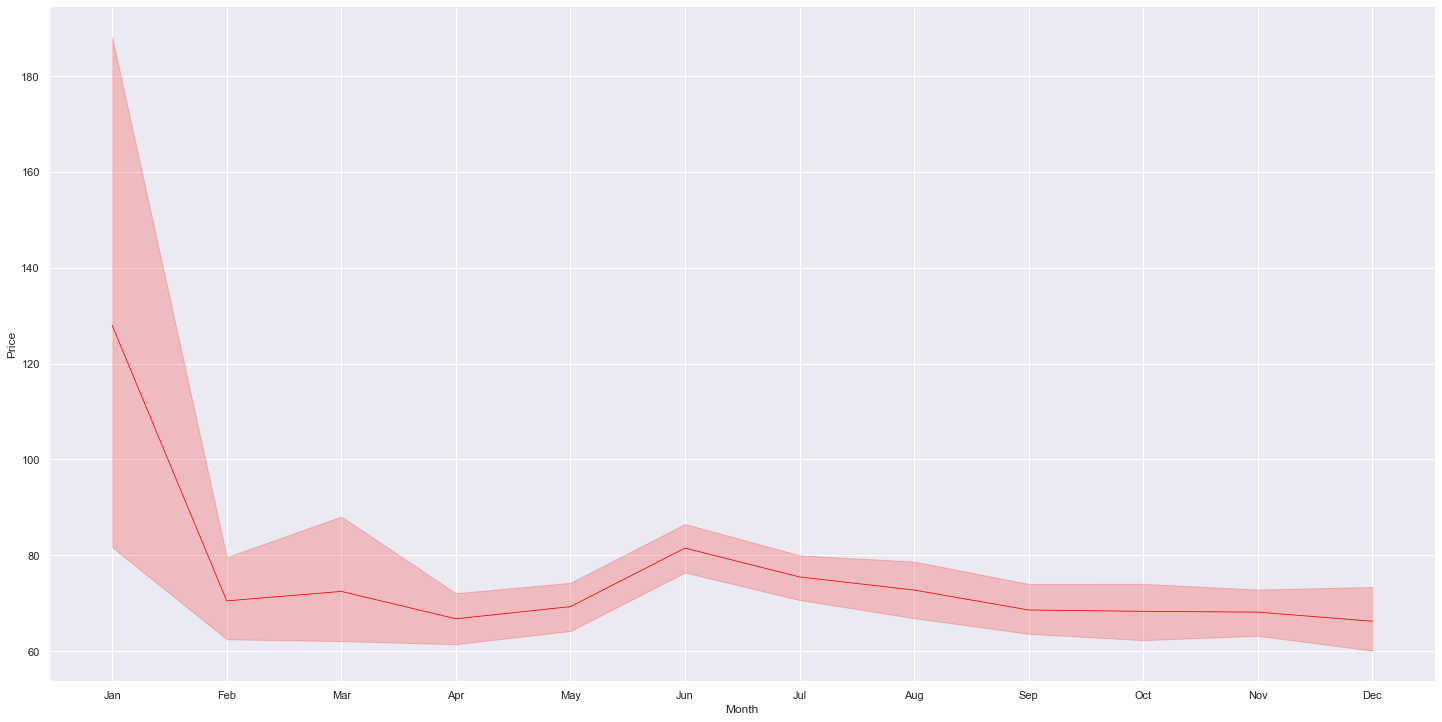

<Figure size 720x576 with 0 Axes>

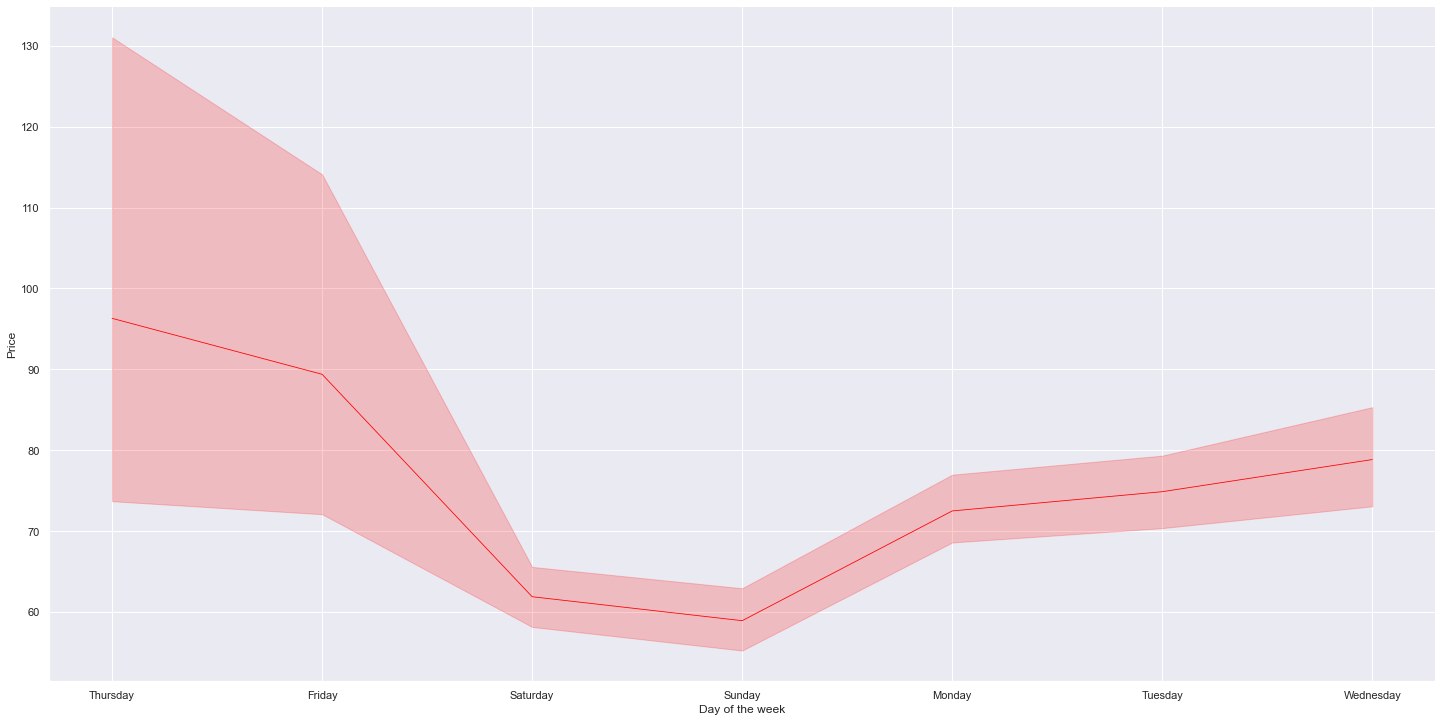

In [10]:
#Visualization of the relationship between date(year, month) and price
plt.figure(figsize=(10, 8))
sns.set_theme(style="darkgrid")
fig = sns.relplot(
    x = 'date_year', y = 'price', 
    kind = 'line', data=df, height=10, aspect=2, 
    linewidth = 0.8, color = 'red'
)
fig.set(xlabel = 'Year', ylabel = 'Price')

plt.figure(figsize=(10, 8))
sns.set_theme(style="darkgrid")
fig = sns.relplot(
    x = 'date_month', y = 'price', 
    kind = 'line', data=df, height=10, aspect=2, 
    linewidth = 0.8, color = 'red'
)
fig.set(xlabel = 'Month', ylabel = 'Price')

plt.figure(figsize=(10, 8))
sns.set_theme(style="darkgrid")
fig = sns.relplot(
    x = 'date_day', y = 'price', 
    kind = 'line', data=df, height=10, aspect=2, 
    linewidth = 0.8, color = 'red'
)
fig.set(xlabel = 'Day of the week', ylabel = 'Price')

<Figure size 720x576 with 0 Axes>

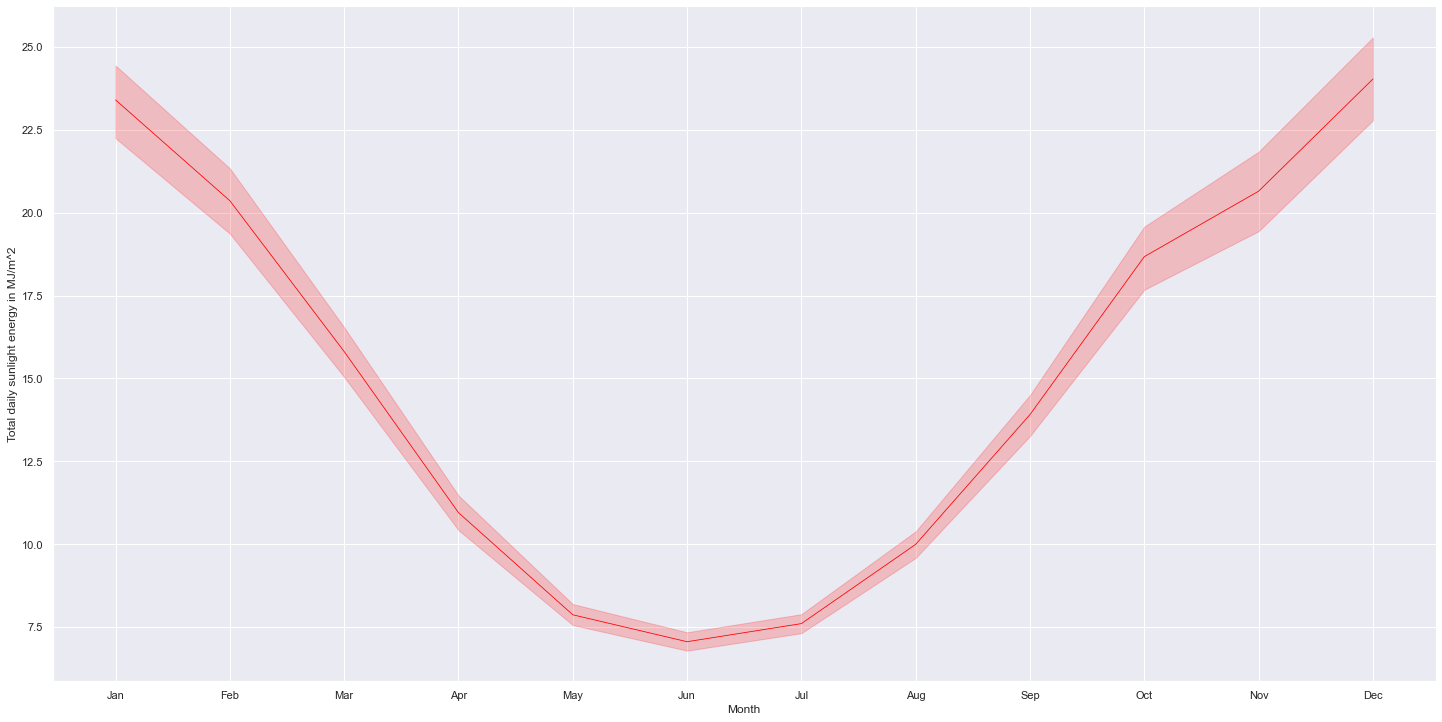

In [11]:
#Visualization of the relationship between date(month) and total daily sunlight energy in MJ/m^2
plt.figure(figsize=(10, 8))
sns.set_theme(style="darkgrid")
fig = sns.relplot(
    x = df['date_month'], y = 'solar_exposure', 
    kind = 'line', data = df, height=10, aspect=2, 
    linewidth = 0.8, color = 'red'
)
fig.set(xlabel = 'Month', ylabel = 'Total daily sunlight energy in MJ/m^2')

[Text(0.5, 0, 'Holiday day'), Text(0, 0.5, 'Price')]

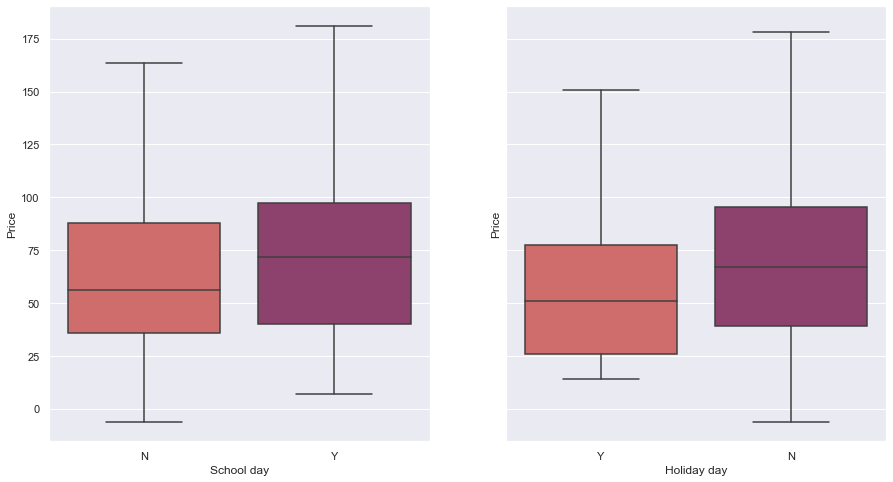

In [12]:
#Visualization how school day and holiday impact on the price
fig, axes = plt.subplots(1, 2, figsize = (15, 8), sharey = True)

fig = sns.boxplot(
    x = 'school_day', y = 'price', 
    data = df, showfliers = False, 
    ax = axes[0], palette = 'flare'
)
fig.set(xlabel = 'School day', ylabel = 'Price')

fig = sns.boxplot(
    x = 'holiday', y = 'price', 
    data = df, showfliers = False, 
    ax = axes[1], palette = 'flare'
)
fig.set(xlabel = 'Holiday day', ylabel = 'Price')

[Text(0.5, 0, 'Maximum temperature during the day in Celsius'),
 Text(0, 0.5, 'Density')]

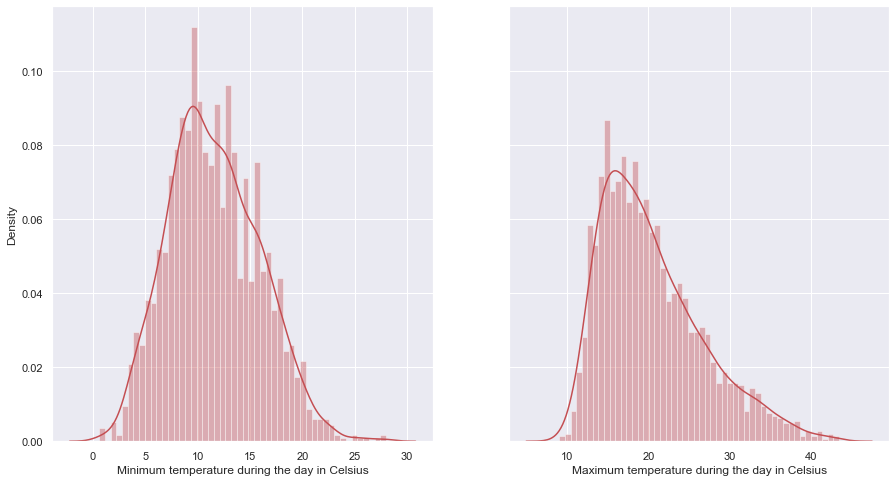

In [13]:
#Visualization of distribution for temperatures
fig, axes = plt.subplots(1, 2, figsize = (15, 8), sharey = True)

fig = sns.distplot(
    x = df['min_temperature'], 
    bins = 50, 
    color = 'r',
    ax = axes[0]
)
fig.set(xlabel = 'Minimum temperature during the day in Celsius', 
        ylabel = 'Density')

fig = sns.distplot(
    x = df['max_temperature'], 
    bins = 50, 
    color = 'r',
    ax = axes[1]
)
fig.set(xlabel = 'Maximum temperature during the day in Celsius', 
        ylabel = 'Density')

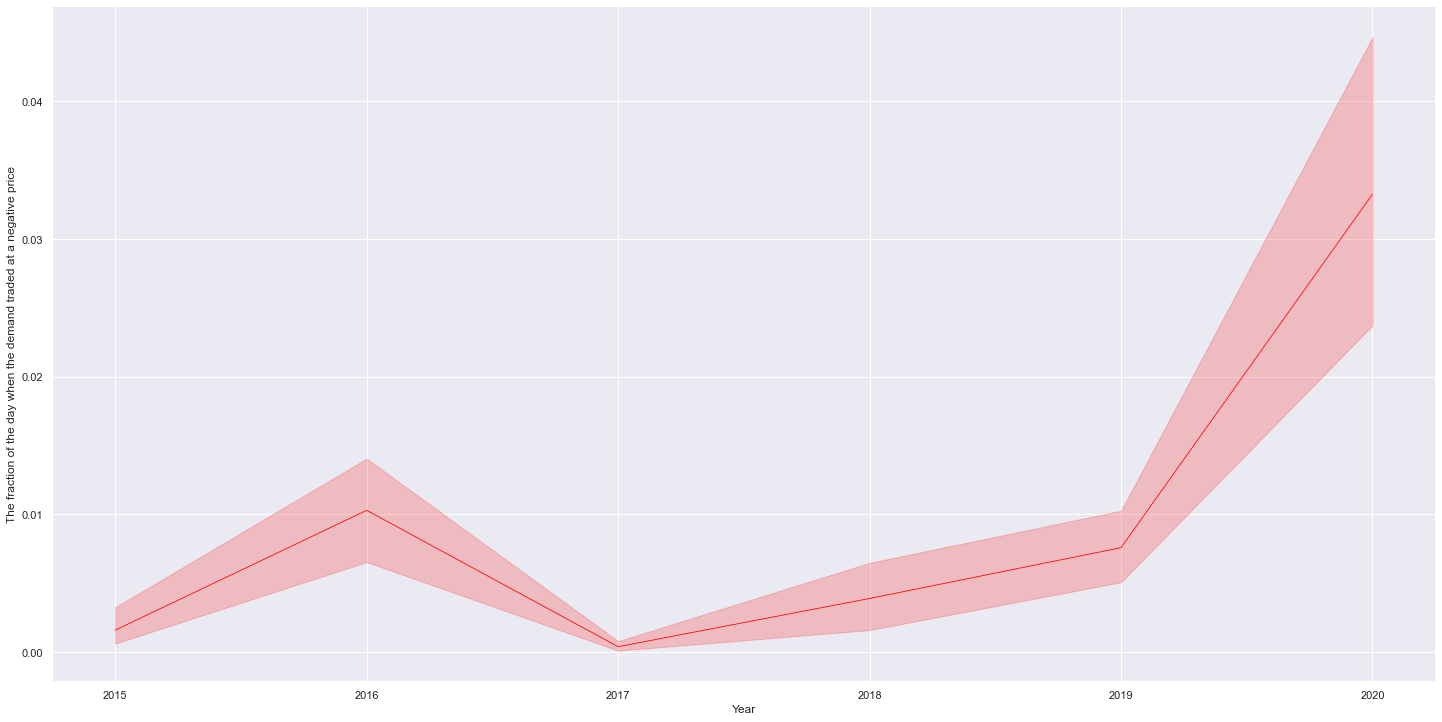

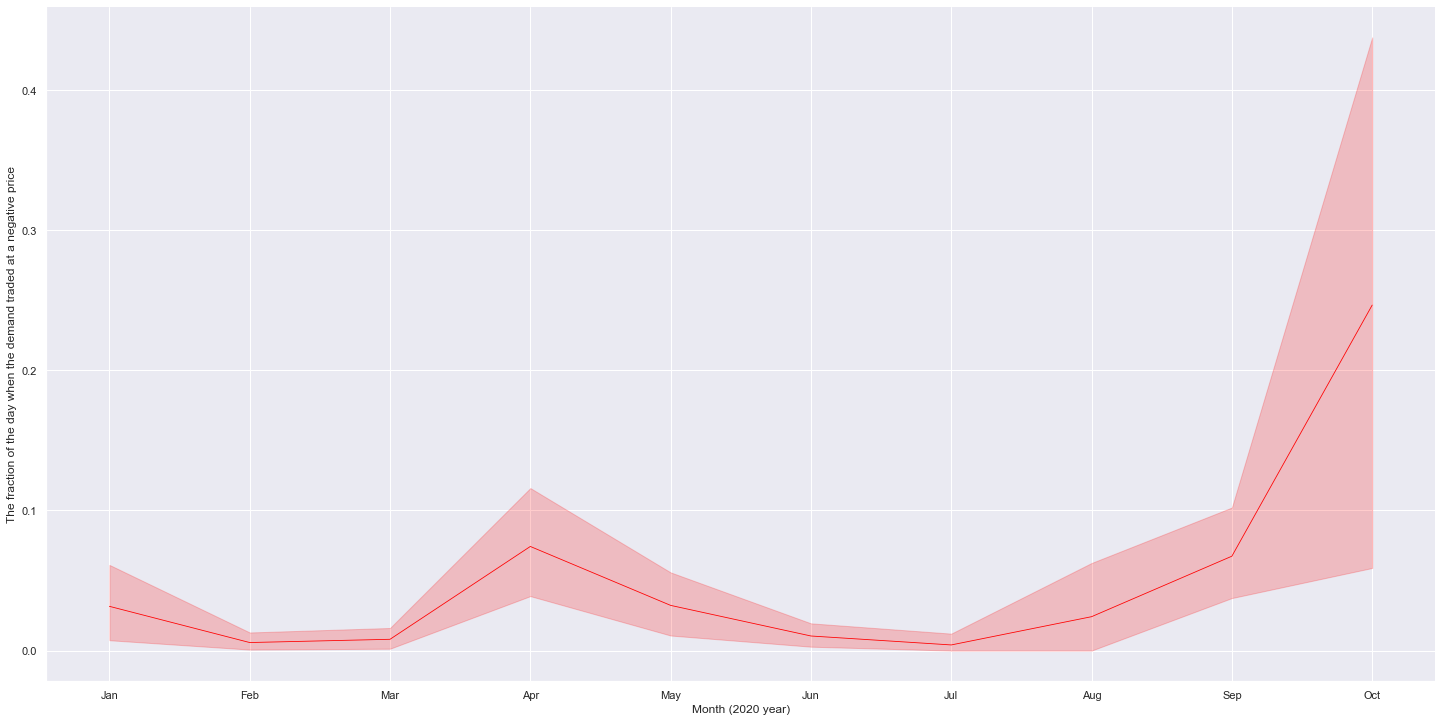

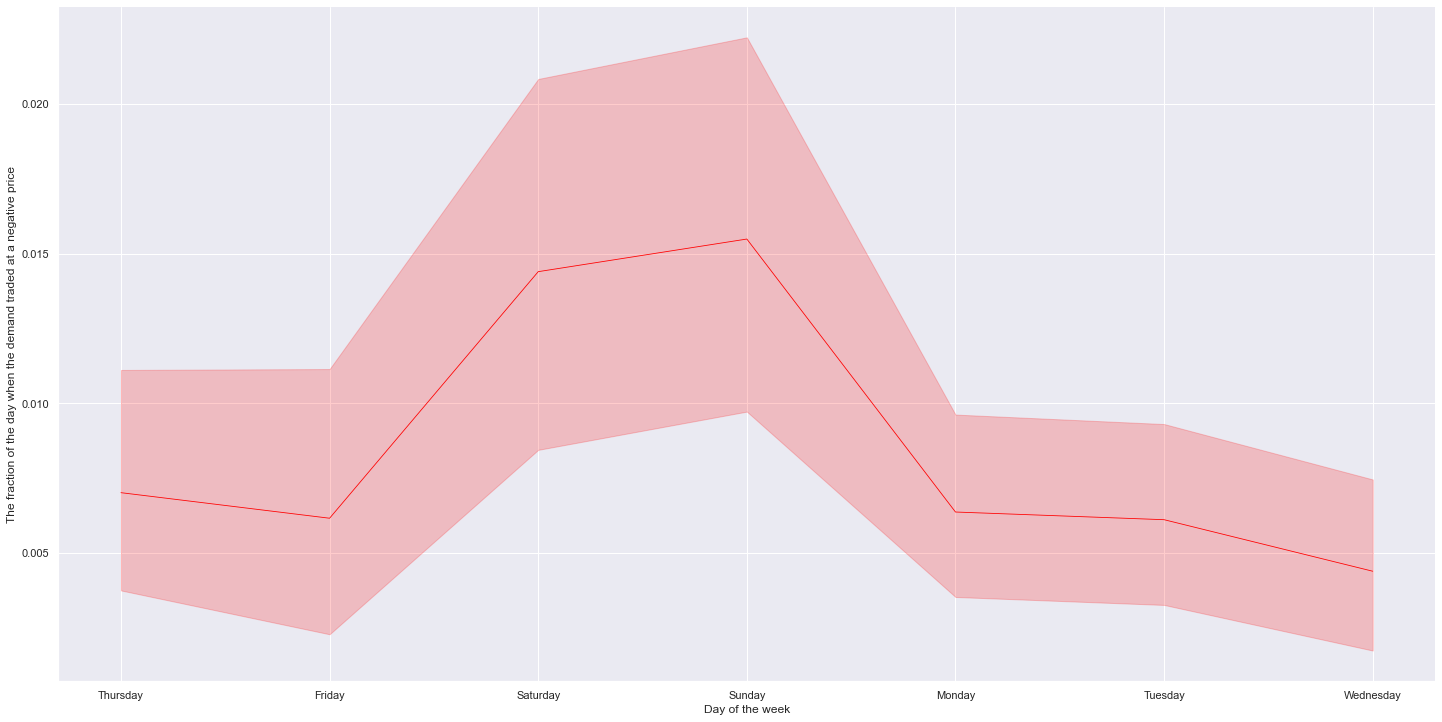

In [14]:
#Visualization of the fraction of the day when the demand traded at a negative price with years, months
df_for_frac = df[df['date_year'] == 2020]

fig = sns.relplot(
    x = 'date_year', y = 'frac_neg_price', kind = 'line', 
    data = df, height = 10, aspect = 2, 
    linewidth = 0.8, color = 'red'
)
fig.set(xlabel = 'Year', 
        ylabel = 'The fraction of the day when the demand traded at a negative price')


fig = sns.relplot(
    x = 'date_month', y = 'frac_neg_price', kind = 'line', 
    data = df_for_frac, height = 10, aspect = 2, 
    linewidth = 0.8, color = 'red'
)
fig.set(xlabel = 'Month (2020 year)', 
        ylabel = 'The fraction of the day when the demand traded at a negative price')

fig = sns.relplot(
    x = 'date_day', y = 'frac_neg_price', kind = 'line', 
    data = df, height = 10, aspect = 2, 
    linewidth = 0.8, color = 'red'
)
fig.set(xlabel = 'Day of the week', 
        ylabel = 'The fraction of the day when the demand traded at a negative price')

In [15]:
#Avarage values of important columns by years
df.groupby('date_year')[['price', 'demand', 'frac_neg_price']].mean()

,price,demand,frac_neg_price
date_year,,,
2015,35.061505,124610.512527,0.001603
2016,50.094252,121989.538757,0.010303
2017,94.772100,118981.167294,0.000401
2018,94.694986,118842.578292,0.003903
2019,117.281370,117939.613397,0.007591
2020,61.266055,117189.901268,0.033259


In [16]:
#Avarage values of important columns by months
df.groupby(['date_month'])[['price', 'demand', 'frac_neg_price', 'solar_exposure']].mean()

,price,demand,frac_neg_price,solar_exposure
date_month,,,,
Apr,66.740784,112245.103556,0.016088,10.949444
Aug,72.732320,128559.799140,0.011985,9.993011
Dec,66.229981,113432.891581,0.007527,24.032903
Feb,70.476061,119850.617706,0.003309,20.361176
Jan,127.970679,119096.530054,0.006048,23.403763
Jul,75.476441,131799.381022,0.003584,7.601075
Jun,81.490087,131707.883911,0.002444,7.054749
Mar,72.450579,116220.643871,0.001792,15.810215
May,69.272424,120767.550995,0.010865,7.867204


In [17]:
#Avarage values of important columns by days of the week
df.groupby(['date_day'])[['price', 'demand', 'frac_neg_price']].mean()

,price,demand,frac_neg_price
date_day,,,
Friday,89.377332,124098.625017,0.006160
Monday,72.477842,121825.294601,0.006368
Saturday,61.867345,111023.493189,0.014396
Sunday,58.902943,106974.765617,0.015486
Thursday,96.301665,125983.682683,0.007014
Tuesday,74.858778,124628.817583,0.006111
Wednesday,78.832474,125749.761823,0.004390


In [18]:
#Transforming data by yeo-johnson method for normalizing distribution
columns = ['price', 'demand']
pt = PowerTransformer(method='yeo-johnson')
df[columns] = pt.fit_transform(df[columns])


<AxesSubplot:xlabel='demand', ylabel='price'>

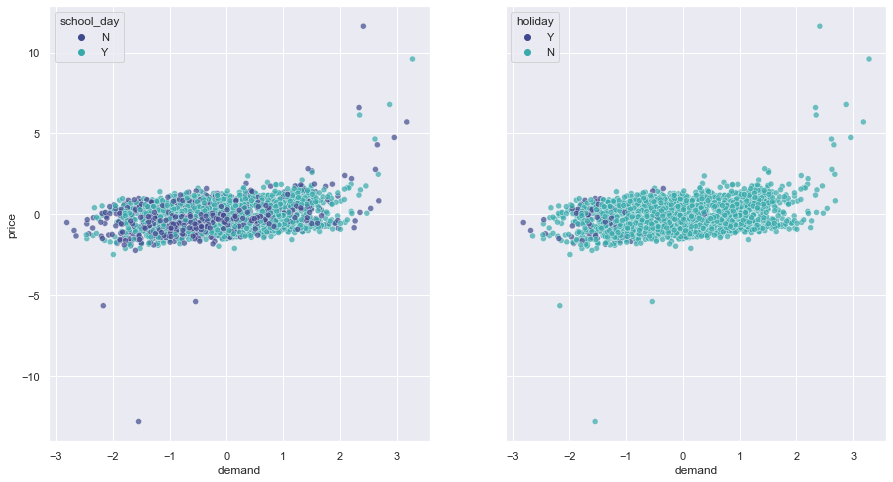

In [19]:
#Visualization price and demand with holiday and school day
fig, axes = plt.subplots(1, 2, figsize = (15, 8), sharey = True)
sns.scatterplot(
    x = 'demand', y = 'price',
    hue = 'school_day',
    data = df, alpha = 0.7,
    ax = axes[0], palette = 'mako'
)

sns.scatterplot(
    x = 'demand', y = 'price',
    hue = 'holiday',
    data = df, alpha = 0.7,
    ax = axes[1], palette = 'mako'
)

<AxesSubplot:xlabel='demand', ylabel='price'>

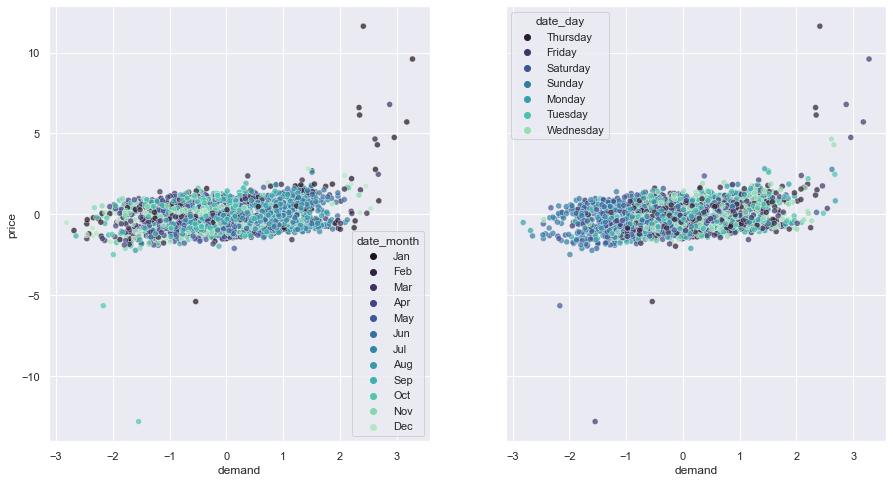

In [20]:
#Visualization price and demand with months and days of the week
fig, axes = plt.subplots(1, 2, figsize = (15, 8), sharey = True)
sns.scatterplot(
    x = 'demand', y = 'price',
    hue = 'date_month',
    data = df, alpha = 0.7,
    ax = axes[0], palette = 'mako'
)

sns.scatterplot(
    x = 'demand', y = 'price',
    hue = 'date_day',
    data = df, alpha = 0.7,
    ax = axes[1], palette = 'mako'
)

[Text(0.5, 0, 'Price'), Text(0, 0.5, 'Density')]

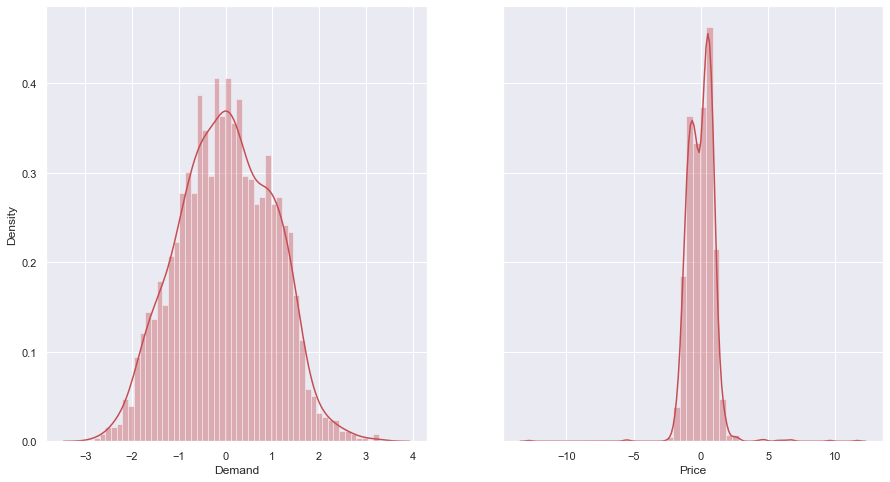

In [21]:
#Visualization of distribution for temperatures
fig, axes = plt.subplots(1, 2, figsize = (15, 8), sharey = True)

fig = sns.distplot(
    x = df['demand'], 
    bins = 50, 
    color = 'r',
    ax = axes[0]
)
fig.set(xlabel = 'Demand', 
        ylabel = 'Density')


fig = sns.distplot(
    x = df['price'], 
    bins = 50, 
    color = 'r',
    ax = axes[1]
)
fig.set(xlabel = 'Price', 
        ylabel = 'Density')

In [22]:
#Transforming data into categorical type
cat_cols = ['school_day', 'holiday', 'date_month', 'date_day']
df[cat_cols] = df[cat_cols].astype('category')
label_encoder = LabelEncoder()
for column_name in df:
    if df[column_name].dtype.name == 'category':
        df[column_name] = label_encoder.fit_transform(df[column_name])

In [23]:
#Working with categorical data and deleting outliers in 'price'
df_final = pd.get_dummies(
    data = df, 
    columns = ['holiday', 'school_day', 
               'date_year', 'date_month', 'date_day']
)

df_final = df_final[df_final['price'] < 5]
df_final = df_final[df_final['price'] > -5]

<Figure size 1080x576 with 0 Axes>

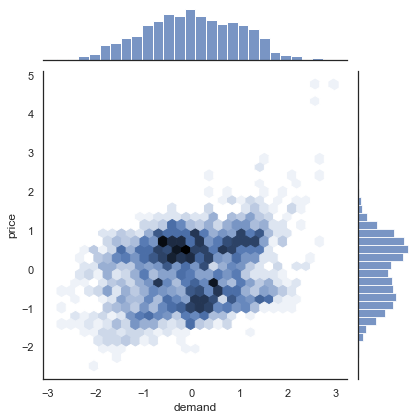

In [24]:
#Visualization price and demand with their distribution
plt.figure(figsize=(15, 8))
sns.set_style('white')
sns.jointplot(
    x = 'demand', y = 'price',
    data = df_final, kind = 'hex',
    palette = 'mako'
)

In [25]:
#Dropping columns which have multi-coll
df_final.drop([
    'date', 'demand_pos_price', 
    'demand_neg_price', 'price_positive',
    'price_negative', 'min_temperature',
    'max_temperature', 'solar_exposure'
], axis = 1, inplace = True
)

In [26]:
#Modeling of data
X = df_final.drop(['price'], axis = 1)
y = df_final['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.4, random_state = 42) 

In [27]:
#Applying of Random Forest
ln = RandomForestRegressor(max_depth = 8, min_samples_leaf = 5, random_state = 42)

# Fit grid_mse to the data
ln.fit(X_train, y_train)
x_pred = ln.predict(X_train)
y_pred = ln.predict(X_test)

print('Coefficient of determination for train sample', r2_score(y_train, x_pred))
print('Coefficient of determination for test sample', r2_score(y_test, y_pred))

print('RMSE for train sample:', np.sqrt(mean_squared_error(y_train, x_pred)))
print('RMSE for test sample:', np.sqrt(mean_squared_error(y_test, y_pred)))

Coefficient of determination for train sample 0.8164967925190381
Coefficient of determination for test sample 0.7518940774110814
RMSE for train sample: 0.3544258276576214
RMSE for test sample: 0.43215810266136534


In [28]:
#Applying of Linear Regression
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)
x_pred = reg.predict(X_train)
y_pred = reg.predict(X_test)

print('Coefficient of determination for train sample', r2_score(y_train, x_pred))
print('Coefficient of determination for test sample', r2_score(y_test, y_pred))

print('RMSE for train sample:', np.sqrt(mean_squared_error(y_train, x_pred)))
print('RMSE for test sample:', np.sqrt(mean_squared_error(y_test, y_pred)))

Coefficient of determination for train sample 0.7283014012320848
Coefficient of determination for test sample 0.7248316121446221
RMSE for train sample: 0.431267996885552
RMSE for test sample: 0.45511732072032984


In [29]:
#Applying of XGBoosting
gbm_param_grid = {
    'max_depth': [2, 5, 10],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 1, 3, 5]
}

# Instantiate the regressor: gbm
gbm = xgb.XGBRegressor(random_state = 42)

# Perform grid search: grid_mse
grid_mse = GridSearchCV(
    estimator = gbm, param_grid = gbm_param_grid, 
    verbose = 0, cv = 4, 
    scoring = 'neg_mean_squared_error')


# Fit grid_mse to the data
grid_mse.fit(X_train, y_train)
x_pred = grid_mse.predict(X_train)
y_pred = grid_mse.predict(X_test)

print('Coefficient of determination for train sample', r2_score(y_train, x_pred))
print('Coefficient of determination for test sample', r2_score(y_test, y_pred))

print('RMSE for train sample:', np.sqrt(mean_squared_error(y_train, x_pred)))
print('RMSE for test sample:', np.sqrt(mean_squared_error(y_test, y_pred)))

Coefficient of determination for train sample 0.8542703725444115
Coefficient of determination for test sample 0.7822578911873879
RMSE for train sample: 0.31584751159752916
RMSE for test sample: 0.40485108424995564
